# GOROKHOV ARTEM

# Neural Network for CIFAR classification. Regularisation.

In this hometask you'll implement and train a neural network for classification of images of CIFAR dataset. In this hometask, we will also learn about two types of regularisation layers that are widely used in NNs — Dropout and BatchNorm, and you will add them to your network for CIFAR classification.

CIFAR is a dataset of RGB images containing 10 classes. Here's the list of the classes and their indices:


| Label        | Class           |
| ------------- |:-------------:|
| 0     | Airplane |
| 1    | Automobile      |
| 2 | Bird      |
| 3 | Cat      |
| 4 | Deer      |
| 5 | Dog      |
| 6 | Frog     |
| 7 | Horse     |
| 8 | Ship     |
| 9 | Truck     |



Let's also create a dictionary mapping class indices to the names. We will need it later for converting model outputs to class names.

In [1]:
class_to_label = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

label_to_class = {name: idx for idx, name in class_to_label.items()}

Here's how images in CIFAR look like:

![alt text](https://miro.medium.com/v2/0*BdetXYemwXwOqNTs.jpg)

## Loading data

In [2]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from IPython.display import clear_output

We'll use `torchvision` library to load the dataset this time.

In [3]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/vqf0qQnpb34dbA) -o cifar_10.zip
! unzip -qq cifar_10.zip


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  162M  100  162M    0     0  8119k      0  0:00:20  0:00:20 --:--:-- 9242k


## Task 1. Implement dataset class for CIFAR data (10 points)

Your task is to implement Dataset class for processing CIFAR data.

Some things to think about:
- do not load all the images into memory in `__init__` method. Store only images paths, and load image based on index from disk only in `__getitem__` method
- think about how to store info about available images and their corresponding labels in `__init__` method. Remember that you need to implement `__len__` method, which should return total number of elements (i.e. number of images) in data.
- remember that you don't need to shuffle data in dataset class, this is done in dataloader (which you don't need to implement).
- Don't forget that you need to store labels as integers between 0 and 9. Use `label_to_class` dict defined above to convert names into numbers.
- When you load the images, they most likely will be represented as arrays with elements in range [0, 255], representing intencities of RGB values of pixels. You'll need to normalise the data. There are different approaches to that. As a simple idea, you might divide all the values by 255. so that they become in a range of [0, 1]. You can try other ideas for normalising as part of this assignment.

In [4]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, images_paths, transform=None):
        '''
        method for dataset initialisation
        images_paths — path to the folder with data
        '''
        
        self.data = []
        
        for class_name in os.listdir(images_paths):
            class_dir = os.path.join(images_paths, class_name)
            if os.path.isdir(class_dir):
                label_int = label_to_class[class_name]
                for fname in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, fname)
                    self.data.append((file_path, label_int))

        self.transform = transform
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor()
            ])

    def __len__(self):
        '''
        method returning length of the data
        '''
        
        return len(self.data)

    def __getitem__(self, idx):
        '''
        method that given an index idx returns an element
        corresponding to that index from the dataset
        '''

        img_path, label = self.data[idx]
        
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            image_tensor = self.transform(img)
        
        return image_tensor, label

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_data = CustomDataset('./cifar10/train', transform=transform)
test_data = CustomDataset('./cifar10/test', transform=transform)

Let's also split training data into train and **validation** parts, so we can check metrics on validation part between training epochs

**Couple of words about validation data:**
In the practical session, we only used training and testing datasets. We trained neural network for some epochs on training data, and then tested trained model on testing data. However, the process of training of neural network (gradient descent) is iterative, and we would like to be able to catch the moment during training when our network is trained optimally, not already underfitted and not yet overfitted.

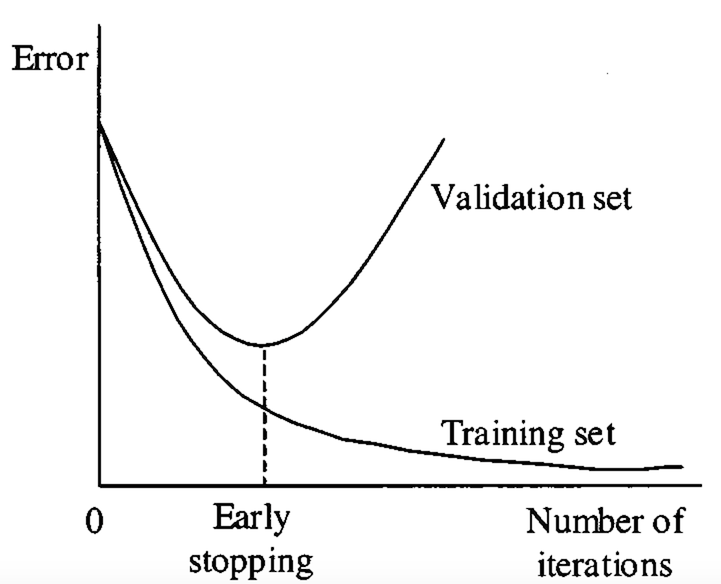


So the logical way to do that is to check loss/accuracy (or any other metric we are interested in) of your network after each epoch on some held-out data different from training data. We could use testing data for that, but then there's a risk of overfitting for the test data. The thing is, if we use testing data for deciding when to stop training, we are actually choosing the model that behaves best on the testing data. So testing data is actually affecting our choice of the best model, so we can't use this same data for final testing anymore, as we always need to test the model on data that was not involved in training or hyperparameters choice anyhow. That is why we need to have distinct validation dataset, which is used to estimate the performance of the model after each epoch and choose the best model. And after obtaining the final model, we will test it on the testing data.

So the logic here is similar to the logic of having validation dataset in classical machine learning, which you've discussed previously. Validation data is used to pick the hyperparmeters, and testing data should only be used purerly for testing the final model.

In practice, in training of neural networks this is most often done as follows: neural network is trained on large number of epochs, and after each epoch its weights are saved, and loss on validation data is calculated and saved as well. After training is done, the best epoch is determined as that having best validation loss, and weights corresponding to that epoch are loaded into the model. This is considered as final model.

Sometimes, hovewer, it is effifient to stop training if for some consecutive epochs validation loss is not going down. In this case we assume that the overfitting has begun and validation loss will not improve anymore again.  This is called **early stopping**.

So let's split our training data into training and validation parts:

In [6]:
# we will allocate 80% of all images to the training sample
train_size = int(len(train_data) * 0.8)
# the remaining 20% will go to validation
val_size = len(train_data) - train_size

# splitting the data
torch.manual_seed(42)
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Now let's take a look at a few pictures to understand what we are dealing with.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.280587..2.6366696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3199205..2.0318506].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1238415..1.6134483].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3199205..2.6171591].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.925058..2.734221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2018826..2.3396237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.024918..2

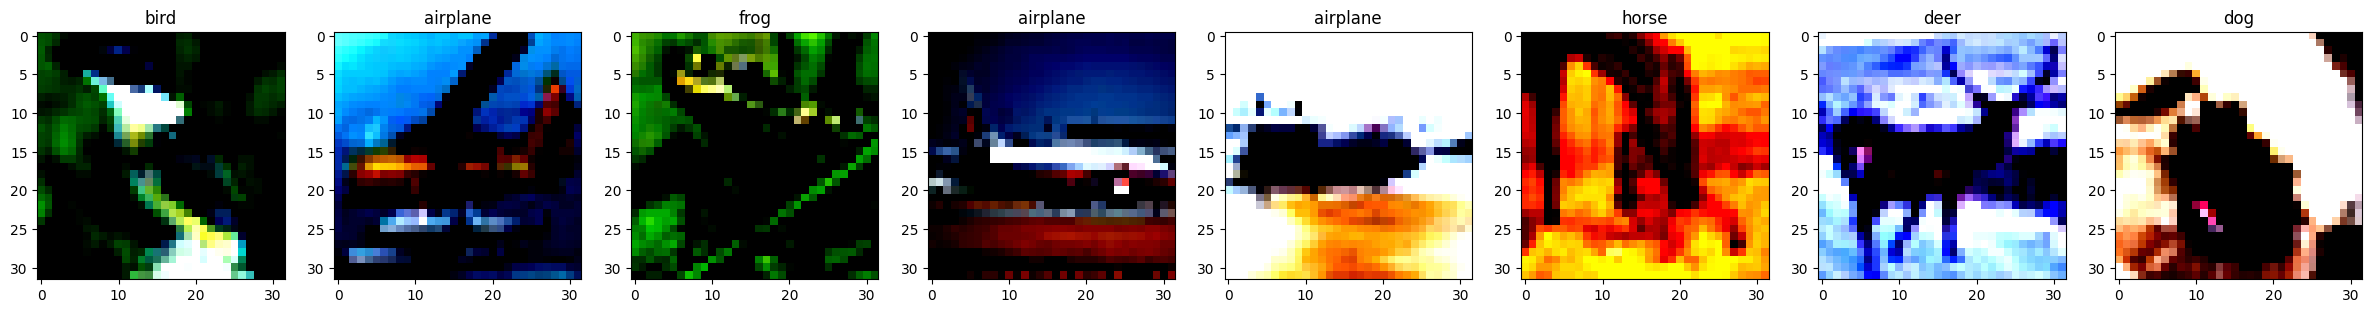

In [7]:
# create a plot with 8 subplots to visualise 8 images
f, axes= plt.subplots(1, 8, figsize=(30,5))

for i, axis in enumerate(axes):
    img, label = train_data[i]
    img = img.permute(1, 2, 0)
    axes[i].imshow(img) # they look strange because of normalization
    axes[i].set_title(class_to_label[label])
plt.show()

Let's see what size the pictures are:

In [8]:
img, label = train_data[0]
img.shape

torch.Size([3, 32, 32])

Here, 3 is the number of color channels (since the image is colored, RGB) and 32 and 32 are the width and height of the image.

Finally, let's define dataloaders for training, validation and testing parts. You can choose your favourite `batch_size` and experiment with that in next tasks.

In [9]:
from torch.utils.data import DataLoader
# batch_size there was changed during experiments
# when we set higher values there model converges faster
train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=4)

## Task 2. CIFAR classification with a fully-connected network.

Your second task is to build and train a fully-connected network for CIFAR classification. After you play with it and see how good accuracy we can get, in the third task we will talk about additional regularisation layers that we can add to our network to make it more efficient.

CIFAR dataset defines the task of multi-class classification into 10 classes. Below there is some theory on how we design neural networks for multi-class classification. If you're already familiar with that, you can skip it and move to the task 2.1

### Neural Network for multi-class classification

We already know how to build a neural network for the tasks of binary classification and regression. Let's learn what to do if we have a task of multi-class classification.

Consider a dataset for classification of crocodiles into 3 types:

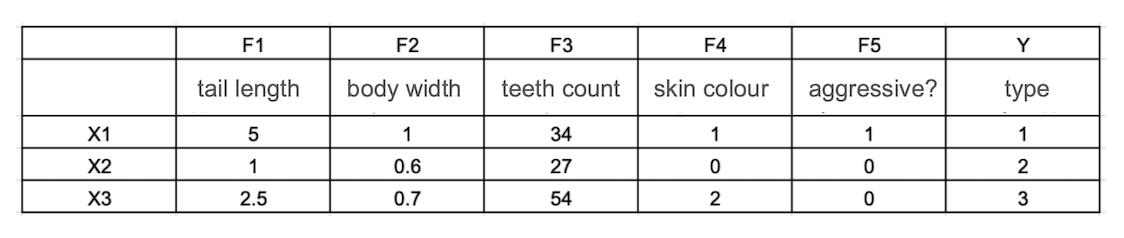

The simplest idea of neural network architecture for this task would be having one output neuron, which would output the class number of input object.

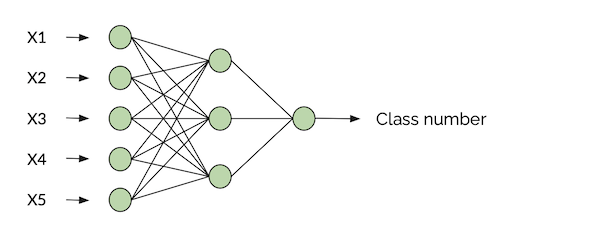

But there's a problem: how do we interpret outputs of such network? Let's say for some object our network outputs the value of 2.12. Does it mean that most likely our object belongs to the class 2? Or does the network think that the object is somewhere in between classes 1 and 3?

Okay, this was not the greatest idea. Let's now note, that a task of milti-class classification to $n$ classes can be wieved as $n$ binary classification tasks:
- does element belong to class 1?
- does element belong to class 2?
- ...
- does element belong to class n?

We can then make our neural network have n output neurons with Sigmoid activation function, and each output neuron will solve a corresponding binary classification tasks. So in our case with crocodile data it will look like that:


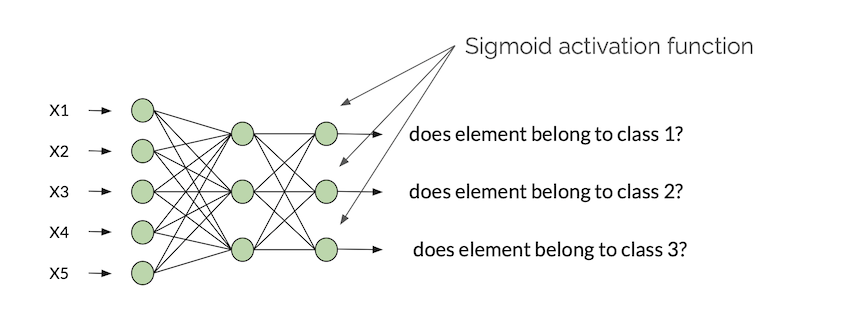

Such a network structure is suitable for the task of multi-label classification, where each input object can belong to arbitrary number of classes, i.e. where events "input object X belongs to class i" are independent. In the case of multi-class classification, these events are not independent, as each object can only belong to one class. So we would like decisions of neuron of the last layer to be agreed in some way.

The idea that comes to mind is the following: we would like neurons of the last layer to output a probability distribution over the classes. This means that the output of $i^{th}$ neuron will represent a probability that the input object belongs to the class $i$.

We also know the true distribution for each object, which is represented as one-hot vector. So as a loss function we could use some similarity measure between the true and predicted distributions.

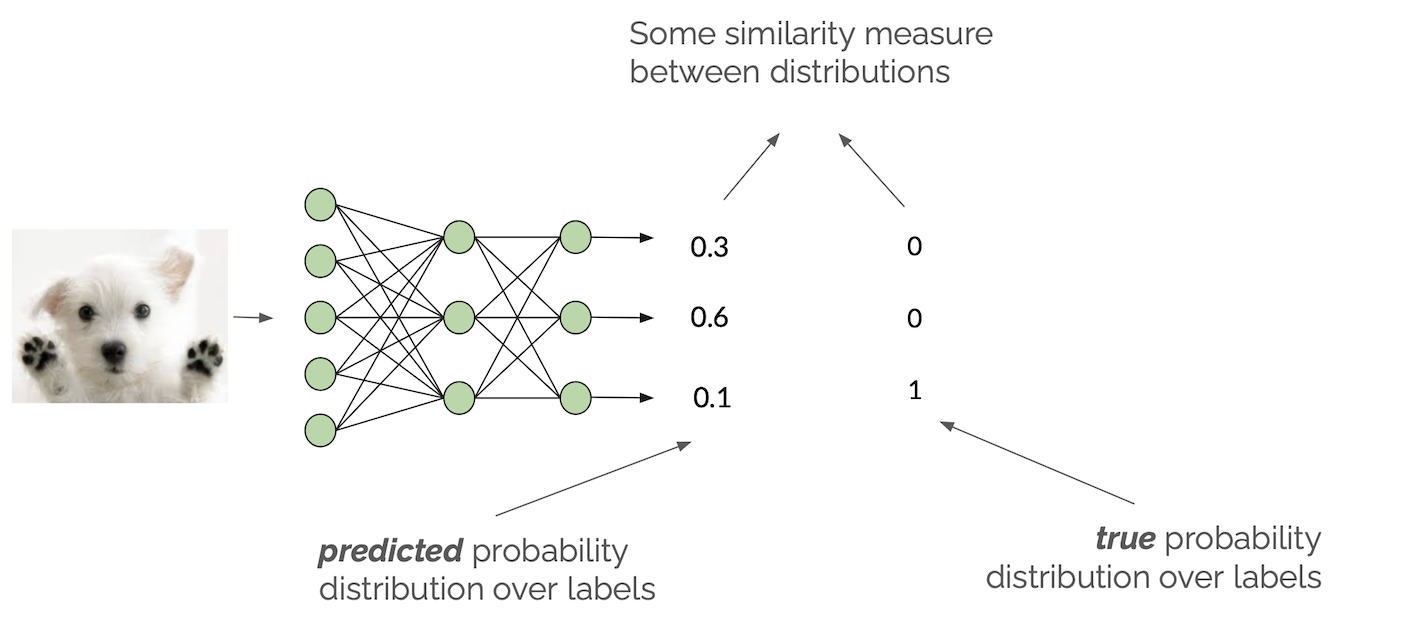

So we need to somehow convert the logits (outputs of the last linear layer) into the probability distribution. Let's do it using SoftMax activation function:

$$(p_1, p_2, p_3) = SoftMax(\widehat{p_1}, \widehat{p_2}, \widehat{p_3}) = \left( \frac{e^{\widehat{p_1}}}{\sum e^{\widehat{p_i}}}, \frac{e^{\widehat{p_2}}}{\sum e^{\widehat{p_i}}}, \frac{e^{\widehat{p_3}}}{\sum e^{\widehat{p_i}}} \right)$$

We can see that SoftMax does indeed convert logits into probability distribution, as the sum of all elements becomes 1, and value of each element is in $[0, 1]$.

And as a similarity measure between the output distribution and true distribution we will use [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy), which is a measure of similarity of two probability distrubutions from information theory.

$$CE(y, p) = - \sum y_i log(p_i)$$

LogLoss is a binary version of cross-entropy.





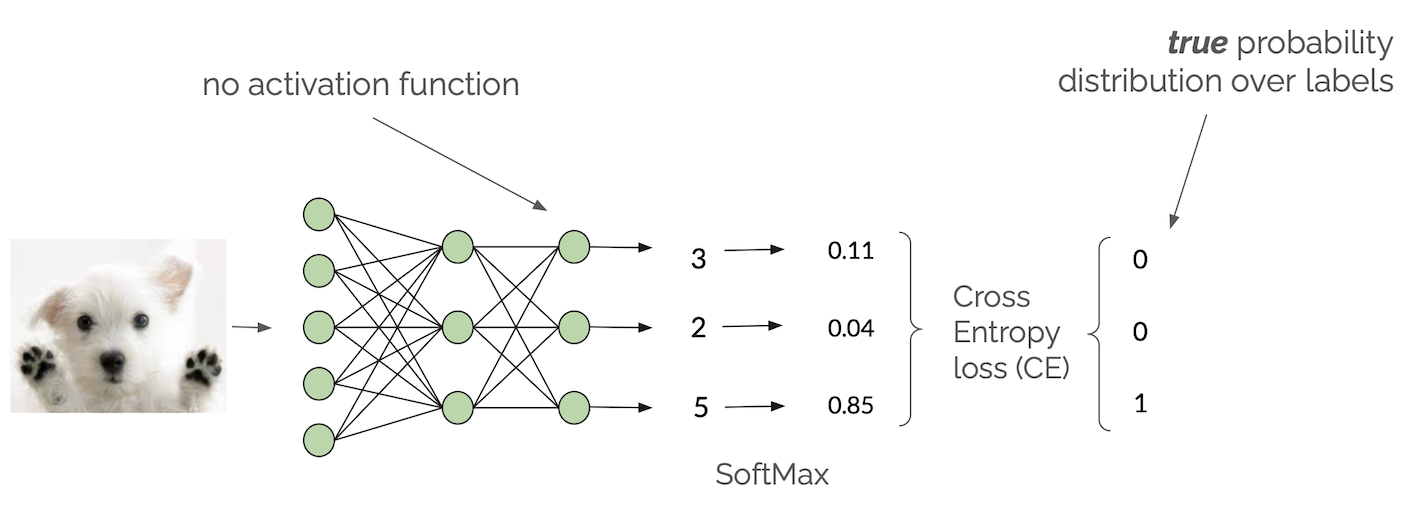

Let's also say a couple of words about why using SoftMax, as there are many ways to convert logits into probability distribution.

First, here's log function inside the formula of cross-entropy. If we pass logits $\widehat{p_i}$ through exponential function before feeding them into cross-entropy, we will end up $log(p_i)$ having the same magnitude as $\widehat{p_i}$. So this will encourage a neural network to output logits which have the same magnitude as $y_i$.

Second, SoftMax is a short for "Soft Maximum", and it has this name because it rebalances the values so that the maximum value becomes more pronounced, close to 1, while all other values get closer to zero.

Here's an example of how SoftMax changes logits:

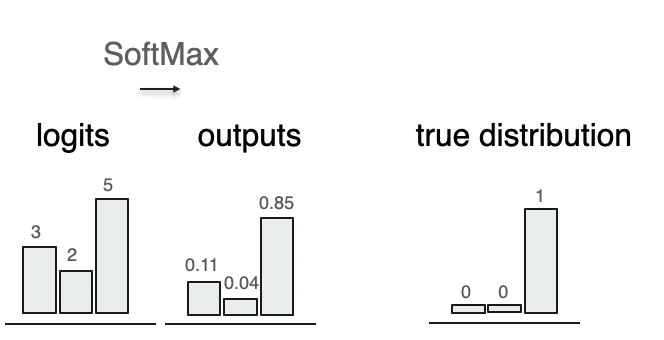

So it is called "Soft Maximum", as it acts almost like argmaximum function, but softer, not putting all the probability weight into one place.

To sum up, if you are building neural network for $n$-class classification task with $n>2$, then:
- last layer of the network should have $n$ neurons
- activation of the last layer of the network should be SoftMax (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- loss function is cross-entropy (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Note, however, that PyTorch implementation of CE (torch.nn.CrossEntropyLoss) expects to have logits as input, not probabilities after SoftMax. It applies SoftMax inside loss function. This is done due to efficiency of computing gradients. So if you use torch.nn.CrossEntropyLoss as loss function, there should be no activation function in the last layer of the network.

### Task 2.1 Write a neural network for CIFAR images classification (5 points)

Here your task is to write any architecture that would process CIFAR image. Think about the following:
- How many input and output neurons you network should have?
- What activation function should the last layer have? We are going to use [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function. What does it get as input according to the documentation?

Note that shape of CIFAR images coming from dataloaders is (3, 32, 32), and we need to flatten images into single vectors. There is a special layer in torch.nn module for this, called [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html). If we use it as the first layer in our model, it will automatically flatten images into vectors.

In [10]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(3 * 32 * 32, 64), # we should set in_features as number of input features which is
                                        # the size of flattened images tensors = 3 * 32 * 32
            nn.ReLU(), # there we set activation function

            nn.Linear(64, 64),
            nn.ReLU(),
            
            nn.Linear(64, 10) # we need to use 10 output neurons since
                              # since torch.nn.CrossEntropyLoss loss function takes
                              # unnormalized logits for each class
            # we do not need to use activation function after the last layes
            # since torch.nn.CrossEntropyLoss loss function takes
            # unnormalized logits for each class
        )

    def forward(self, x):

        x = self.flatten(x)

        x = self.fc(x)

        return x

And create a network:

In [11]:
net = Net()

### Task 2.2. Define a train function. (5 points)

You can borrow the code from practice session. Hovewer, we'll make one addition to the training code: you will need to add evaluation on validation data after each epoch.

Hints:
- Don't forget about the GPU usage! For CIFAR data it becomes important.
- it might also be beneficial to see how training loss evolves during training, this will help you do experiments later. You can either save average of losses on batches per epoch into array and return it as output of the `train` function, so you can then visualize it using [matplotlib.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Or you can add plotting average of losses on batches per epoch inside the `train` function. In this case you might also need using a function to clear output of the cell, so you can draw new plot after each epoch. You can find how to do it [here](https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code)
- Consider saving model weights after each epoch. You can either save weights to different files after each epoch, or save weights each time when validation loss gets smaller than ever before. Don't forget to load best weights after the end of the training.

In [12]:
import tqdm
from tqdm.auto import tqdm
from IPython.display import clear_output

def train(model, train_loader, val_loader, criterion, optimizer, num_epoch):
    '''
    args:
        model - our neural network model
        train_loader — structure which yields batches of training data
        val_loader — structure which yields batches of validation data
        criterion - loss function from `torch.nn` module
        optimizer - optimizer from `torch.optim` module
        num_epoch - number of training epochs
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None

    for epoch in tqdm(range(num_epoch), desc="Training Epochs"):
        # training
        model.train()
        running_loss = 0.0
        num_samples = 0
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * X.size(0)
            num_samples += X.size(0)
            
        train_loss = running_loss / num_samples
        train_losses.append(train_loss)
        
        # validation
        model.eval()
        running_val_loss = 0.0
        num_val_samples = 0
        
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss_val = criterion(outputs, y_val)
                running_val_loss += loss_val.item() * X_val.size(0)
                num_val_samples += X_val.size(0)
                
        val_loss = running_val_loss / num_val_samples
        val_losses.append(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            torch.save(best_model_state, "best_model.pth")
        
        print(f"Epoch [{epoch+1}/{num_epoch}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epoch+1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, num_epoch+1), val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Evolution")
    plt.legend()
    plt.grid(True)
    plt.show()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Best model weights loaded.")
    
    return model

And let's define loss function, optimizer, dataloader and train our network.

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10]  Train Loss: 1.7333  Val Loss: 1.6000
Epoch [2/10]  Train Loss: 1.5243  Val Loss: 1.5461
Epoch [3/10]  Train Loss: 1.4430  Val Loss: 1.4984
Epoch [4/10]  Train Loss: 1.3787  Val Loss: 1.4703
Epoch [5/10]  Train Loss: 1.3282  Val Loss: 1.4592
Epoch [6/10]  Train Loss: 1.2879  Val Loss: 1.4727
Epoch [7/10]  Train Loss: 1.2524  Val Loss: 1.4600
Epoch [8/10]  Train Loss: 1.2174  Val Loss: 1.4441
Epoch [9/10]  Train Loss: 1.1839  Val Loss: 1.4678
Epoch [10/10]  Train Loss: 1.1573  Val Loss: 1.4631


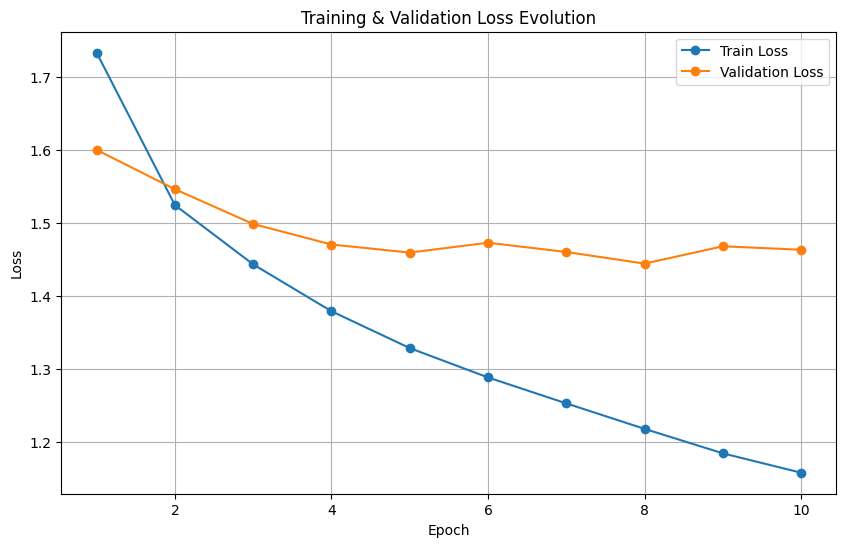

Best model weights loaded.


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)

# run training
num_epochs = 10
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

### Task 2.3. Write a code for model evaluation (5 points)

After we train our neural network, we'll need to evaluate it on test data and compute accuracy metric. Let's now define the function for it. Your task is to fill the gaps in the code below.

In [14]:
def evaluate(model, loader, criterion):
    '''
    args:
        model - our neural network model
        loader — structure which yields batches of test data
        criterion - loss function from `torch.nn` module
    '''
    
    losses = []
    y_pred_list = []
    y_true_list = []

    model.eval()
    
    for X_batch, y_batch in loader:
        with torch.no_grad():
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            losses.append(loss.item())
            
            preds = torch.argmax(outputs, dim=1)
            
        y_pred_list.extend(preds.cpu().tolist())
        y_true_list.extend(y_batch.cpu().tolist())

    accuracy = np.mean(np.array(y_pred_list) == np.array(y_true_list))
    
    return np.mean(losses), accuracy

And let's evaluate our trained network on test data.

In [15]:
evaluate(best_net, test_loader, criterion)

(1.427386124432087, 0.5043)

### Task 2.4. Train the best neural network to classify CIFAR data (20 points)

Now you have a network that can be trained and evaluated on binary classification data. Your next task is to make it better, so that your neural network can achieve as high accuracy as possible on the test part.

You are free to build any neural network architecture you want and use any hyperparameters for training. Here are some tips:
- Start with no more than 2-3 hidden layers each having 5-7 neurons
- Think about how many neurons your input and output layers should have
- What activation function do you need to use in the last layer?
- Play with number of layers, numbers of neurons in layers, different activation functions
- Try different training **hyperparameters**: learning rate, number of epochs, type of optimizer, batch size
- Try different kinds of image preprocessing inside you Dataset class, e.g. resizing/normalising images, etc.

After you've done experimenting, describe your findings. Try to answer the following questions:
- What is maximum accuracy on test test that you were able to achieve? Do you think it is possible to get higher accuracy using fully-connected network? Why?
- Have you observed overfitting? When does it start, i.e. how big the network should be?
- How does the behaviour of the model change when you change different hyperparameters?
- What interesting behaviour have you observed? What was beneficial and what did not influence the model?

Here is also a hint on experimenting: try to change one parameter at time. When you change the parameter, retrain the network and see how the behaviour has changes. Log the results, so you can then a general picture of how each parameter influences the model training. This will also help you not to forget what you have already tried.





**Answers**

1. Maximum accuracy I achieved was near 56%. I think it is possible to achieve better accuracy with FC network, but without regularisation techniques it might be difficult and accuracy improvement won't be sufficiently better due to overfitting issues.
2. Overfitting can be clearly observed when there are ~1,000,000 parameters in the model after ~16th epoch (see the chart below).

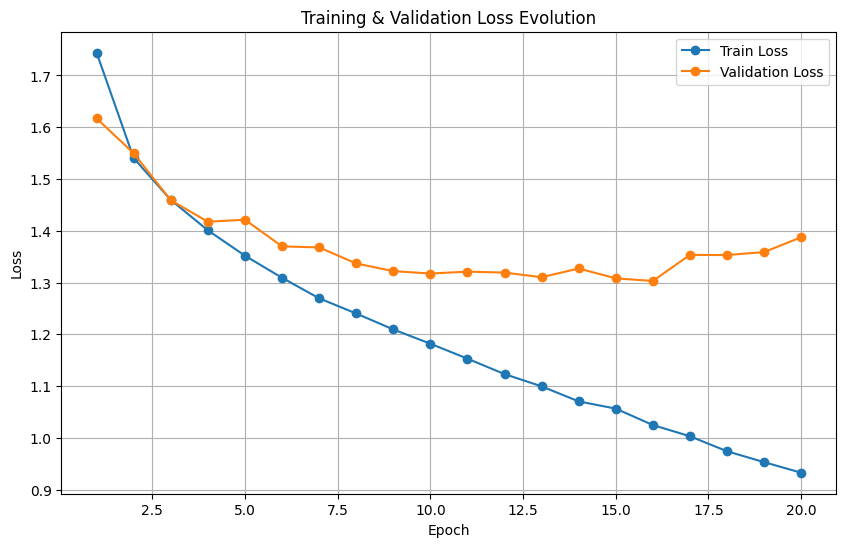

3. 
- LR increases $\longrightarrow$ faster convergence, higher overfitting risk and instability
- LR decreases $\longrightarrow$ slower convergence, slower training process
- Number of epochs increases $\longrightarrow$ more likely to catch overfitting
- Number of epochs decreases $\longrightarrow$ less likely to catch overfitting, but underfitting possibility
- Larger batch size $\longrightarrow$ more stable training process, larger memory consumption
- Smaller batch size $\longrightarrow$ noisier weights updates

4. 
- Augmentation can boost model's performance, for example RandomHorizontalFlip and RandomRotation were helpful
- torch.nn.ReLU() activation function shows better results than torch.nn.Tanh() and works faster

I've also tried there techniques used in ResNet and DenseNet: combining hidden states with some previous ones, but that didn't give sufficient boost. I think that could be useful in deeper networks to avoid gradient vanishing, but optimal network here is not too deep.

In [16]:
# there we define the model class and its architecture
# usually models with higher number of parameters can be trained better
# for more complex tasks, but they also have higher risk of overfitting

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

sum([p.numel() for p in net.parameters()])

444170

In [17]:
# there we define train augmentations, they help to build more robust model
train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100]  Train Loss: 2.0285  Val Loss: 1.8149
Epoch [2/100]  Train Loss: 1.7397  Val Loss: 1.6851
Epoch [3/100]  Train Loss: 1.6394  Val Loss: 1.6177
Epoch [4/100]  Train Loss: 1.5810  Val Loss: 1.5791
Epoch [5/100]  Train Loss: 1.5417  Val Loss: 1.5569
Epoch [6/100]  Train Loss: 1.5114  Val Loss: 1.5199
Epoch [7/100]  Train Loss: 1.4839  Val Loss: 1.4935
Epoch [8/100]  Train Loss: 1.4654  Val Loss: 1.4811
Epoch [9/100]  Train Loss: 1.4441  Val Loss: 1.4698
Epoch [10/100]  Train Loss: 1.4275  Val Loss: 1.4618
Epoch [11/100]  Train Loss: 1.4137  Val Loss: 1.4448
Epoch [12/100]  Train Loss: 1.3969  Val Loss: 1.4209
Epoch [13/100]  Train Loss: 1.3840  Val Loss: 1.4199
Epoch [14/100]  Train Loss: 1.3717  Val Loss: 1.4089
Epoch [15/100]  Train Loss: 1.3583  Val Loss: 1.4066
Epoch [16/100]  Train Loss: 1.3496  Val Loss: 1.3927
Epoch [17/100]  Train Loss: 1.3367  Val Loss: 1.3856
Epoch [18/100]  Train Loss: 1.3263  Val Loss: 1.3761
Epoch [19/100]  Train Loss: 1.3205  Val Loss: 1.3682
Ep

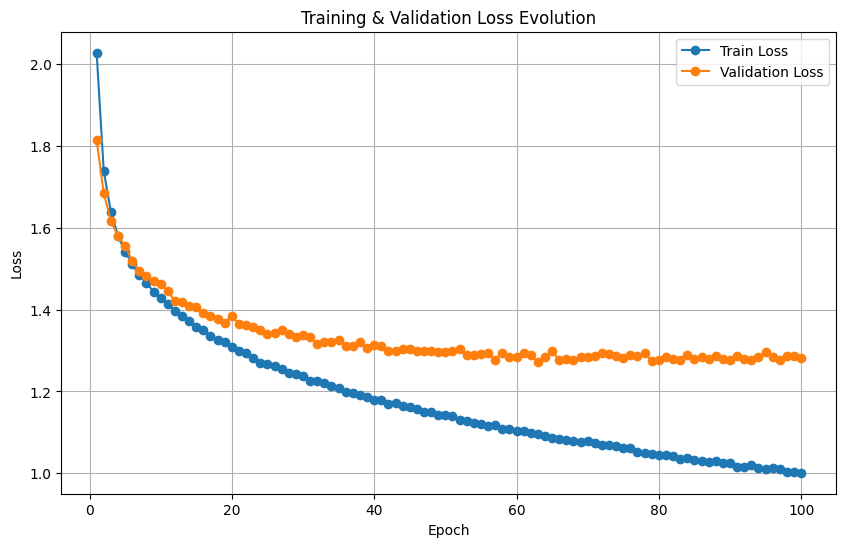

Best model weights loaded.


In [18]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4) # there we set learning rate
                                                         # when lower walues are set, the model converges slower,
                                                         # but risk of overfitting decreases

# run training
num_epochs = 100 # there we set number of epochs
                 # we should pick the number to avoid both underfitting and overfitting
                 # the lower num_epochs the higher risk of underfitting
                 # the higher num_epochs the higher risk of underfitting, but we load the best model
                 # according to the validation loss, so it should be the optimal, not overfitted model
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [19]:
evaluate(best_net, test_loader, criterion)

(1.246609479188919, 0.5601)

### Experiments

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20]  Train Loss: 1.7841  Val Loss: 1.6896
Epoch [2/20]  Train Loss: 1.6114  Val Loss: 1.6074
Epoch [3/20]  Train Loss: 1.5320  Val Loss: 1.5188
Epoch [4/20]  Train Loss: 1.4830  Val Loss: 1.4869
Epoch [5/20]  Train Loss: 1.4435  Val Loss: 1.4593
Epoch [6/20]  Train Loss: 1.4147  Val Loss: 1.4347
Epoch [7/20]  Train Loss: 1.3849  Val Loss: 1.4380
Epoch [8/20]  Train Loss: 1.3618  Val Loss: 1.4540
Epoch [9/20]  Train Loss: 1.3406  Val Loss: 1.3962
Epoch [10/20]  Train Loss: 1.3195  Val Loss: 1.4154
Epoch [11/20]  Train Loss: 1.3093  Val Loss: 1.3865
Epoch [12/20]  Train Loss: 1.3018  Val Loss: 1.3898
Epoch [13/20]  Train Loss: 1.2825  Val Loss: 1.3789
Epoch [14/20]  Train Loss: 1.2751  Val Loss: 1.3860
Epoch [15/20]  Train Loss: 1.2544  Val Loss: 1.3975
Epoch [16/20]  Train Loss: 1.2465  Val Loss: 1.3777
Epoch [17/20]  Train Loss: 1.2330  Val Loss: 1.3817
Epoch [18/20]  Train Loss: 1.2278  Val Loss: 1.3670
Epoch [19/20]  Train Loss: 1.2143  Val Loss: 1.3914
Epoch [20/20]  Train 

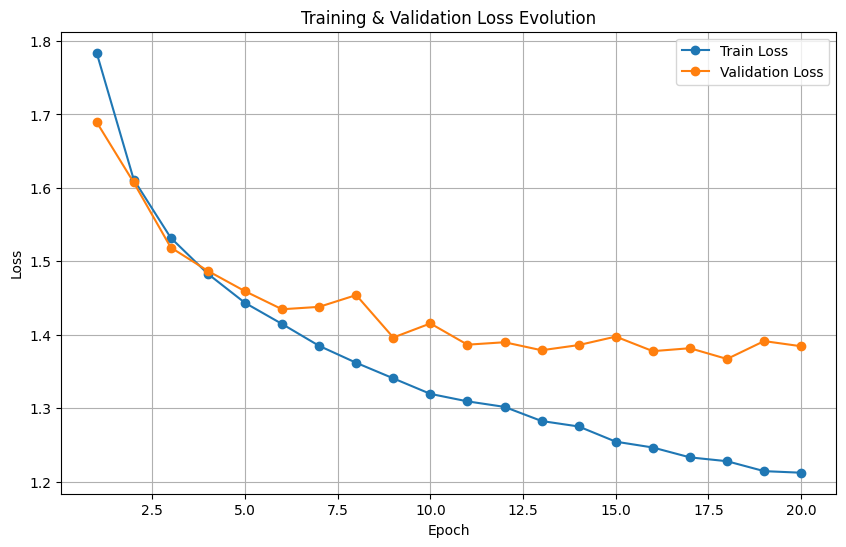

Best model weights loaded.
(1.39650616645813, 0.4983)


In [36]:
# comparing models with different learning rate
# learning rate = 3e-3 = 0.003
# we can observe the beginning of overfitting near 18th epoch since val loss doesn't decrease
# val loss became less than 1.4 on 9th epoch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-3)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20]  Train Loss: 2.0057  Val Loss: 1.8027
Epoch [2/20]  Train Loss: 1.7205  Val Loss: 1.6720
Epoch [3/20]  Train Loss: 1.6249  Val Loss: 1.6095
Epoch [4/20]  Train Loss: 1.5704  Val Loss: 1.5660
Epoch [5/20]  Train Loss: 1.5280  Val Loss: 1.5261
Epoch [6/20]  Train Loss: 1.4998  Val Loss: 1.5031
Epoch [7/20]  Train Loss: 1.4739  Val Loss: 1.5013
Epoch [8/20]  Train Loss: 1.4541  Val Loss: 1.4737
Epoch [9/20]  Train Loss: 1.4370  Val Loss: 1.4573
Epoch [10/20]  Train Loss: 1.4183  Val Loss: 1.4584
Epoch [11/20]  Train Loss: 1.4036  Val Loss: 1.4340
Epoch [12/20]  Train Loss: 1.3895  Val Loss: 1.4235
Epoch [13/20]  Train Loss: 1.3765  Val Loss: 1.4128
Epoch [14/20]  Train Loss: 1.3647  Val Loss: 1.4016
Epoch [15/20]  Train Loss: 1.3555  Val Loss: 1.4016
Epoch [16/20]  Train Loss: 1.3400  Val Loss: 1.3985
Epoch [17/20]  Train Loss: 1.3332  Val Loss: 1.3898
Epoch [18/20]  Train Loss: 1.3237  Val Loss: 1.3948
Epoch [19/20]  Train Loss: 1.3119  Val Loss: 1.3858
Epoch [20/20]  Train 

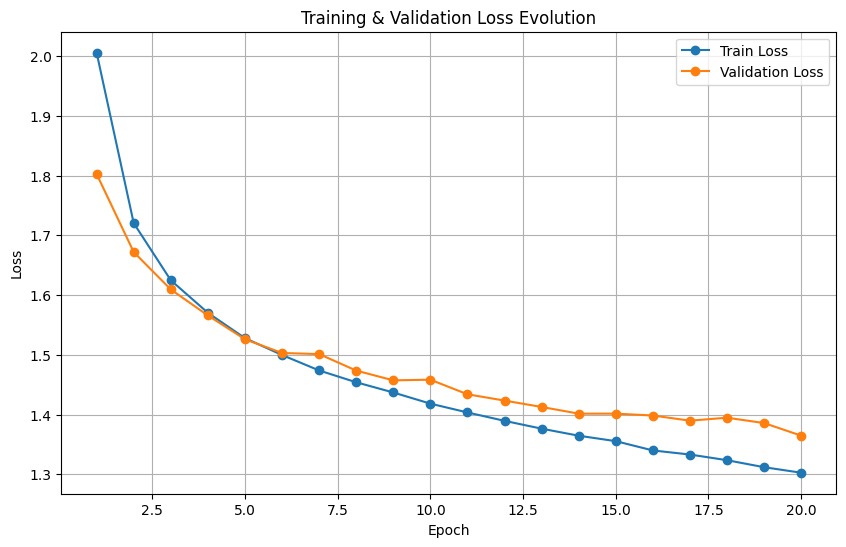

Best model weights loaded.
(1.3407223492860794, 0.5176)


In [ ]:
# comparing models with different learning rate
# learning rate = 1e-4 = 0.0001
# overfitting haven't begun in first 20 epochs
# val loss became less than 1.4 on 16th epoch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch [1/200]  Train Loss: 2.0078  Val Loss: 1.8107
Epoch [2/200]  Train Loss: 1.7302  Val Loss: 1.6819
Epoch [3/200]  Train Loss: 1.6378  Val Loss: 1.6142
Epoch [4/200]  Train Loss: 1.5812  Val Loss: 1.5722
Epoch [5/200]  Train Loss: 1.5423  Val Loss: 1.5426
Epoch [6/200]  Train Loss: 1.5085  Val Loss: 1.5190
Epoch [7/200]  Train Loss: 1.4819  Val Loss: 1.4896
Epoch [8/200]  Train Loss: 1.4596  Val Loss: 1.4877
Epoch [9/200]  Train Loss: 1.4393  Val Loss: 1.4618
Epoch [10/200]  Train Loss: 1.4240  Val Loss: 1.4532
Epoch [11/200]  Train Loss: 1.4087  Val Loss: 1.4379
Epoch [12/200]  Train Loss: 1.3937  Val Loss: 1.4305
Epoch [13/200]  Train Loss: 1.3795  Val Loss: 1.4133
Epoch [14/200]  Train Loss: 1.3692  Val Loss: 1.4165
Epoch [15/200]  Train Loss: 1.3607  Val Loss: 1.4033
Epoch [16/200]  Train Loss: 1.3463  Val Loss: 1.3887
Epoch [17/200]  Train Loss: 1.3349  Val Loss: 1.4012
Epoch [18/200]  Train Loss: 1.3268  Val Loss: 1.3815
Epoch [19/200]  Train Loss: 1.3211  Val Loss: 1.3799
Ep

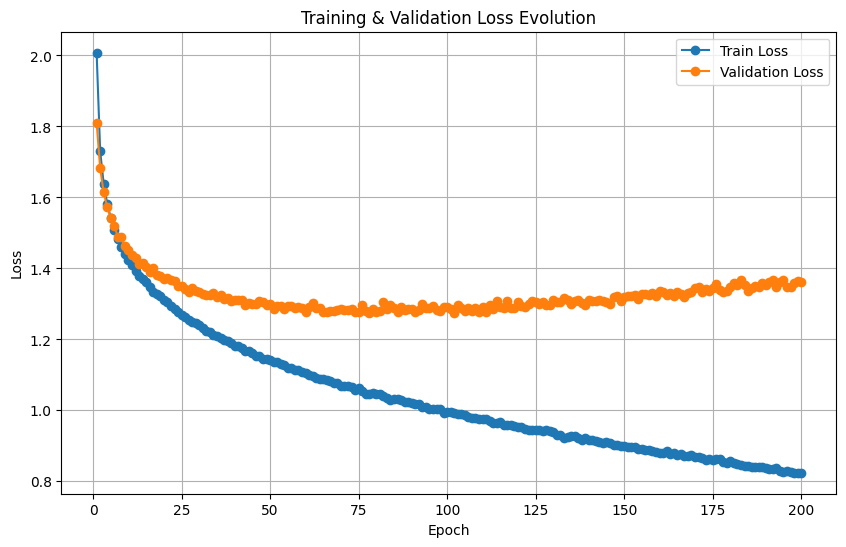

Best model weights loaded.
(1.2925382792949676, 0.5675)


In [ ]:
# comparing models with different number of epochs
# there we can train one model and look at losses on different epochs
# we can see that the model trained 25 epochs haven't converged as much as possible yet
# but after 75 epochs model begins overfitting since val loss increases

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  Train Loss: 1.7516  Val Loss: 1.6104
Epoch [2/50]  Train Loss: 1.5516  Val Loss: 1.5241
Epoch [3/50]  Train Loss: 1.4797  Val Loss: 1.4922
Epoch [4/50]  Train Loss: 1.4347  Val Loss: 1.4536
Epoch [5/50]  Train Loss: 1.3905  Val Loss: 1.4025
Epoch [6/50]  Train Loss: 1.3555  Val Loss: 1.4074
Epoch [7/50]  Train Loss: 1.3267  Val Loss: 1.3835
Epoch [8/50]  Train Loss: 1.3007  Val Loss: 1.3574
Epoch [9/50]  Train Loss: 1.2802  Val Loss: 1.3618
Epoch [10/50]  Train Loss: 1.2570  Val Loss: 1.3500
Epoch [11/50]  Train Loss: 1.2409  Val Loss: 1.3235
Epoch [12/50]  Train Loss: 1.2205  Val Loss: 1.3317
Epoch [13/50]  Train Loss: 1.2036  Val Loss: 1.3170
Epoch [14/50]  Train Loss: 1.1907  Val Loss: 1.3338
Epoch [15/50]  Train Loss: 1.1738  Val Loss: 1.3131
Epoch [16/50]  Train Loss: 1.1617  Val Loss: 1.3352
Epoch [17/50]  Train Loss: 1.1433  Val Loss: 1.3123
Epoch [18/50]  Train Loss: 1.1350  Val Loss: 1.2940
Epoch [19/50]  Train Loss: 1.1163  Val Loss: 1.3115
Epoch [20/50]  Train 

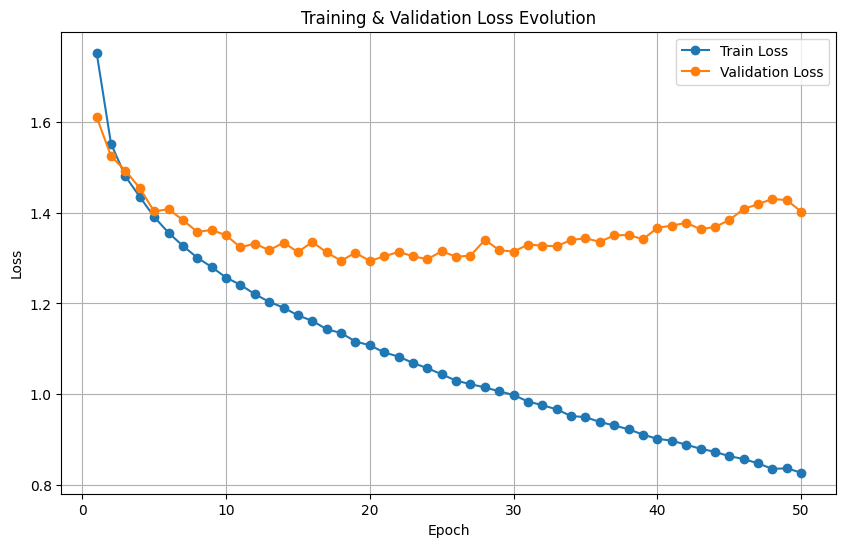

Best model weights loaded.
(1.395642849290447, 0.5398)


In [ ]:
# comparing models with different batch sizes
# batch size = 64
# required time = 02:46

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4)

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  Train Loss: 1.8619  Val Loss: 1.6927
Epoch [2/50]  Train Loss: 1.6238  Val Loss: 1.5868
Epoch [3/50]  Train Loss: 1.5362  Val Loss: 1.5460
Epoch [4/50]  Train Loss: 1.4821  Val Loss: 1.4925
Epoch [5/50]  Train Loss: 1.4418  Val Loss: 1.4532
Epoch [6/50]  Train Loss: 1.4062  Val Loss: 1.4433
Epoch [7/50]  Train Loss: 1.3834  Val Loss: 1.4124
Epoch [8/50]  Train Loss: 1.3533  Val Loss: 1.3899
Epoch [9/50]  Train Loss: 1.3339  Val Loss: 1.3678
Epoch [10/50]  Train Loss: 1.3075  Val Loss: 1.3674
Epoch [11/50]  Train Loss: 1.2927  Val Loss: 1.3435
Epoch [12/50]  Train Loss: 1.2771  Val Loss: 1.3368
Epoch [13/50]  Train Loss: 1.2638  Val Loss: 1.3400
Epoch [14/50]  Train Loss: 1.2448  Val Loss: 1.3229
Epoch [15/50]  Train Loss: 1.2329  Val Loss: 1.3163
Epoch [16/50]  Train Loss: 1.2149  Val Loss: 1.3142
Epoch [17/50]  Train Loss: 1.2030  Val Loss: 1.3065
Epoch [18/50]  Train Loss: 1.1915  Val Loss: 1.3189
Epoch [19/50]  Train Loss: 1.1891  Val Loss: 1.3099
Epoch [20/50]  Train 

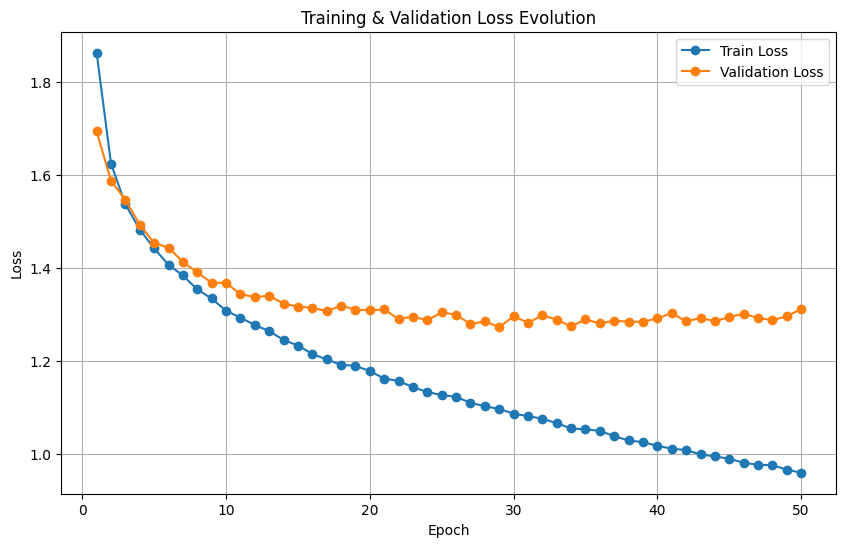

Best model weights loaded.
(1.2952635385096074, 0.5472)


In [ ]:
# comparing models with different batch sizes
# batch size = 256
# test accuracy improved by ~1%
# validation loss updates became less noisier
# overfitting became sufficiently less
# required time = 02:32 - faster training

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=256, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False, num_workers=4)

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  Train Loss: 2.0084  Val Loss: 1.7892
Epoch [2/50]  Train Loss: 1.6969  Val Loss: 1.6445
Epoch [3/50]  Train Loss: 1.5924  Val Loss: 1.5908
Epoch [4/50]  Train Loss: 1.5262  Val Loss: 1.5397
Epoch [5/50]  Train Loss: 1.4731  Val Loss: 1.5040
Epoch [6/50]  Train Loss: 1.4289  Val Loss: 1.4835
Epoch [7/50]  Train Loss: 1.3918  Val Loss: 1.4665
Epoch [8/50]  Train Loss: 1.3567  Val Loss: 1.4538
Epoch [9/50]  Train Loss: 1.3244  Val Loss: 1.4415
Epoch [10/50]  Train Loss: 1.2958  Val Loss: 1.4297
Epoch [11/50]  Train Loss: 1.2689  Val Loss: 1.4253
Epoch [12/50]  Train Loss: 1.2403  Val Loss: 1.4205
Epoch [13/50]  Train Loss: 1.2182  Val Loss: 1.4113
Epoch [14/50]  Train Loss: 1.1923  Val Loss: 1.4158
Epoch [15/50]  Train Loss: 1.1732  Val Loss: 1.4108
Epoch [16/50]  Train Loss: 1.1470  Val Loss: 1.4153
Epoch [17/50]  Train Loss: 1.1263  Val Loss: 1.4191
Epoch [18/50]  Train Loss: 1.1078  Val Loss: 1.4230
Epoch [19/50]  Train Loss: 1.0879  Val Loss: 1.4141
Epoch [20/50]  Train 

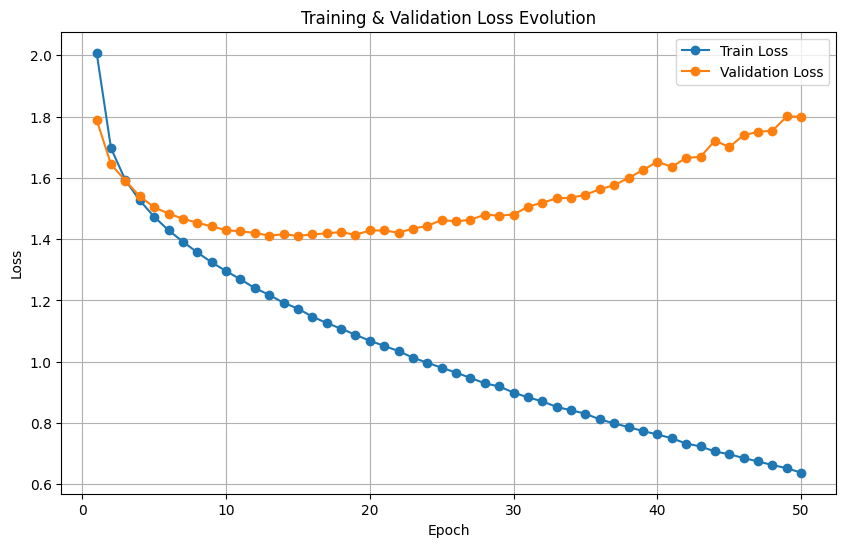

Best model weights loaded.
(1.7627506628632545, 0.5012)


In [ ]:
# comparing models with augmentation and without it
# without augmentation
# overfitting begins after ~15th epoch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  Train Loss: 2.0123  Val Loss: 1.7953
Epoch [2/50]  Train Loss: 1.7271  Val Loss: 1.6844
Epoch [3/50]  Train Loss: 1.6400  Val Loss: 1.6197
Epoch [4/50]  Train Loss: 1.5876  Val Loss: 1.5793
Epoch [5/50]  Train Loss: 1.5453  Val Loss: 1.5544
Epoch [6/50]  Train Loss: 1.5124  Val Loss: 1.5226
Epoch [7/50]  Train Loss: 1.4857  Val Loss: 1.4928
Epoch [8/50]  Train Loss: 1.4638  Val Loss: 1.4761
Epoch [9/50]  Train Loss: 1.4444  Val Loss: 1.4684
Epoch [10/50]  Train Loss: 1.4288  Val Loss: 1.4658
Epoch [11/50]  Train Loss: 1.4096  Val Loss: 1.4414
Epoch [12/50]  Train Loss: 1.3941  Val Loss: 1.4275
Epoch [13/50]  Train Loss: 1.3826  Val Loss: 1.4249
Epoch [14/50]  Train Loss: 1.3713  Val Loss: 1.4050
Epoch [15/50]  Train Loss: 1.3555  Val Loss: 1.4023
Epoch [16/50]  Train Loss: 1.3500  Val Loss: 1.4001
Epoch [17/50]  Train Loss: 1.3371  Val Loss: 1.3818
Epoch [18/50]  Train Loss: 1.3275  Val Loss: 1.3740
Epoch [19/50]  Train Loss: 1.3165  Val Loss: 1.3747
Epoch [20/50]  Train 

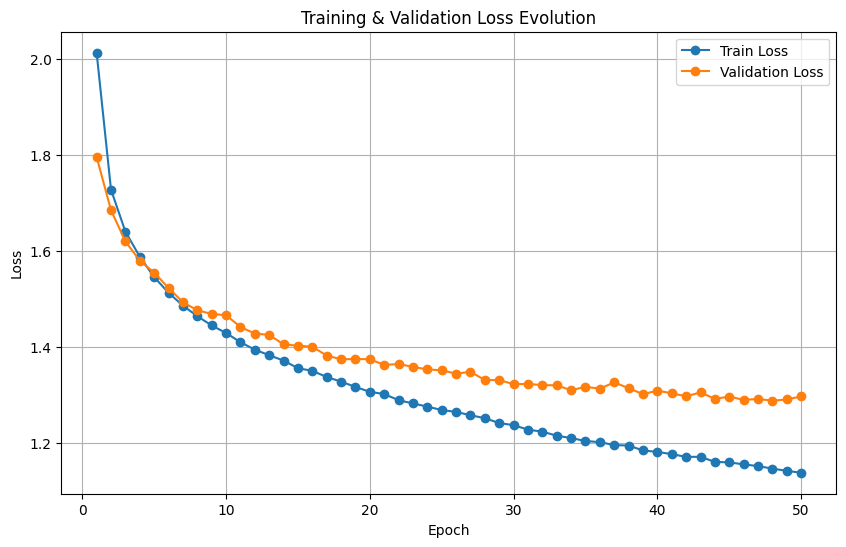

Best model weights loaded.
(1.274517972767353, 0.5418)


In [ ]:
# comparing models with augmentation and without it
# with augmentation
# overfitting haven't begun in first 50 epochs
# test accuracy improved by ~4%

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  Train Loss: 1.9927  Val Loss: 1.8457
Epoch [2/50]  Train Loss: 1.7778  Val Loss: 1.7280
Epoch [3/50]  Train Loss: 1.6812  Val Loss: 1.6569
Epoch [4/50]  Train Loss: 1.6224  Val Loss: 1.6156
Epoch [5/50]  Train Loss: 1.5745  Val Loss: 1.5865
Epoch [6/50]  Train Loss: 1.5423  Val Loss: 1.5598
Epoch [7/50]  Train Loss: 1.5130  Val Loss: 1.5472
Epoch [8/50]  Train Loss: 1.4894  Val Loss: 1.5290
Epoch [9/50]  Train Loss: 1.4717  Val Loss: 1.5107
Epoch [10/50]  Train Loss: 1.4556  Val Loss: 1.5058
Epoch [11/50]  Train Loss: 1.4372  Val Loss: 1.4966
Epoch [12/50]  Train Loss: 1.4215  Val Loss: 1.4860
Epoch [13/50]  Train Loss: 1.4155  Val Loss: 1.4813
Epoch [14/50]  Train Loss: 1.3992  Val Loss: 1.4688
Epoch [15/50]  Train Loss: 1.3921  Val Loss: 1.4618
Epoch [16/50]  Train Loss: 1.3807  Val Loss: 1.4467
Epoch [17/50]  Train Loss: 1.3734  Val Loss: 1.4533
Epoch [18/50]  Train Loss: 1.3629  Val Loss: 1.4477
Epoch [19/50]  Train Loss: 1.3526  Val Loss: 1.4435
Epoch [20/50]  Train 

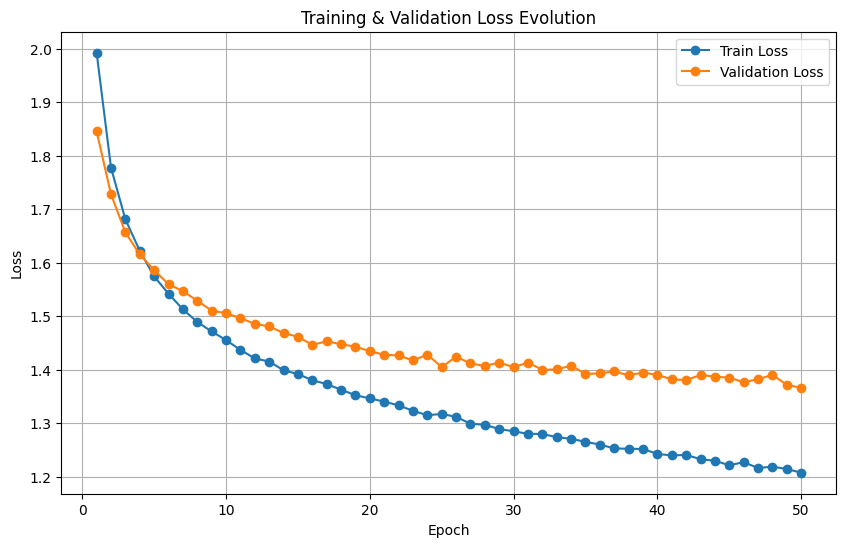

Best model weights loaded.
(1.586790506541729, 0.4503)


In [ ]:
# comparing models with different activation functions
# with torch.nn.Tanh

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.Tanh())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.Tanh())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.Tanh())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.Tanh())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50]  Train Loss: 2.0203  Val Loss: 1.8076
Epoch [2/50]  Train Loss: 1.7266  Val Loss: 1.6785
Epoch [3/50]  Train Loss: 1.6279  Val Loss: 1.6120
Epoch [4/50]  Train Loss: 1.5724  Val Loss: 1.5729
Epoch [5/50]  Train Loss: 1.5356  Val Loss: 1.5413
Epoch [6/50]  Train Loss: 1.5057  Val Loss: 1.5090
Epoch [7/50]  Train Loss: 1.4796  Val Loss: 1.4920
Epoch [8/50]  Train Loss: 1.4588  Val Loss: 1.4796
Epoch [9/50]  Train Loss: 1.4403  Val Loss: 1.4658
Epoch [10/50]  Train Loss: 1.4241  Val Loss: 1.4472
Epoch [11/50]  Train Loss: 1.4064  Val Loss: 1.4334
Epoch [12/50]  Train Loss: 1.3930  Val Loss: 1.4266
Epoch [13/50]  Train Loss: 1.3783  Val Loss: 1.4176
Epoch [14/50]  Train Loss: 1.3664  Val Loss: 1.4092
Epoch [15/50]  Train Loss: 1.3558  Val Loss: 1.3952
Epoch [16/50]  Train Loss: 1.3430  Val Loss: 1.3834
Epoch [17/50]  Train Loss: 1.3312  Val Loss: 1.3756
Epoch [18/50]  Train Loss: 1.3225  Val Loss: 1.3793
Epoch [19/50]  Train Loss: 1.3146  Val Loss: 1.3690
Epoch [20/50]  Train 

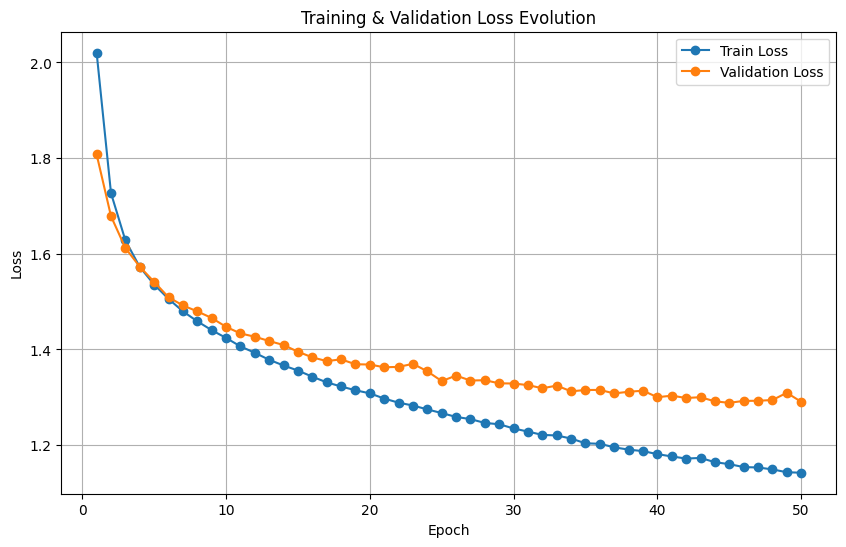

Best model weights loaded.
(1.2657797403633595, 0.5474)


In [ ]:
# comparing models with different activation functions
# with torch.nn.ReLU
# test accuracy improved by ~10%
# faster convergence

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 128), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.hidden_layer_3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        
        self.classifier = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.hidden_layer_3(x)

        x = self.classifier(x)

        return x

net = Net()

train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

num_epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)
print(evaluate(best_net, test_loader, criterion))

## Task 3. Adding regularisation layers

In this section we will get familiar with two powerful techniques for regularizing neural networks — Dropout and BatchNorm. First we'll review the theory, and then you will add them to your network for CIFAR classification.

Note that these techniques (or their modifications) are still used in modern neural networks such as LLMs. We will see it further in the course

### BatchNorm

Let's look at a neural network that has several layers. Note that a subnetwork starting from the $i^{th}$ layer can be seen as a sub-model, which takes outputs of the previous layer as input. We already know that it is important to normalise the input data that we feed into a model. So should we also normalise inputs to hidden layers?

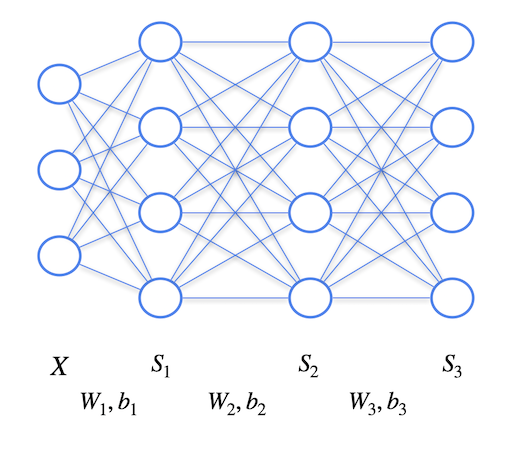

It seems thatwould  normalizing the outputs of each intermediate layer also contribute to more efficient training of the network. And **BatchNorm is the layer that performs such normalization**.

**How does it do that?** The first idea that comes to mind is to do the same thing as with input normalization: let's normalise the output of each neuron so that it has a mean=0 and std=1 across the training data.

But this idea has two issues:
1. In order to shift outputs of each neuron so that thay have fixed mean and std across all the training data, we would first need to calculate each neuron's outputs on all the objects from the training data. This is computationally infeasible.
2. Instead of fixing mean and std of outputs, why not let neural network during training decide itself how it is better to normalise outputs of each layer?  

How to address these two issues? Here are couple of ideas:
1. We may approximate statistics (mean and std) of neuron outputs based on mini-batch data, not based on all the training data.
2. We can introduce trainable parameters that will adjust mean and std of layers' neurons.

BatchNorm is a technique of layer output normalisation that uses these two ideas. **BatchNorm is a trainable layer that normalizes the outputs of the network using trainable parameters**.

So here is what BatchNorm does:

Suppose we have a layer. On a mini-batch training iteration the layer has $b$ outputs $\{x_i\}_{i=1}^b$.

1. Calculate mean $\mu_B$ and std $\sigma_B$ of the layer outputs on a current batch:
$$\mu_B = \frac{\sum_{i=1}^b x_i}{b}$$
$$\sigma^2_B = \frac{\sum_{i=1}^b (x_i - \mu_B)^2}{b}$$
2. Normalise layer outputs using $\mu_B$ and $\sigma_B$:
$$\widehat{x}_i = \frac{x_i - \mu_B}{\sigma_B+ \epsilon}$$
3. Calculate modified layer outputs as follows:
$$y_i = \gamma \widehat{x}_i + \beta$$

Here $\gamma$ and $\beta$ are trainable parameters.

So here happens the following:

* First, on steps 1-2, layer outputs are normalized so that each neuron has mean value of 0 and standard deviation of 1 across elements of the batch.
* Then, on step 3, means and standard deviations of each neuron are shifted by $\beta$ and $\gamma$ respectively. Both $\beta$ and $\gamma$ are trainable parameters, which means that during training the neural network is allowed to adjust mean and standard deviation of layer's outputs. $\beta$ and $\gamma$ are trained together with all the model parameters during gradient descent.



    


So we have described what BatchNorm does during training. **Now let's think about inference.** Here we have one problem: during inference, we want to be able to get the output of a model for a single object, i.e. we can have batch size equal to 1. On step 1 of our BatchNorm algorithm, we calculated mean and std estimates across current batch of data, and if we have only one element in the batch, we can't get reliable mean and std estimates for neurons' outputs.

So what shall we do? The idea is the following: let's gather the statistics of mean and std values calculated for mini-batches during training. And then we will use this statistics during inference. Actually, this aligns with how we normalise input data: during inference we use statistics calculated on the training data to normalise the test data.

So we will need to add one step to the BatchNorm algorithm during training:

Before training, define veriables
$$\mu_r= 0$$
$$\sigma_r = 0$$
We also fix a number $momentum\in[0,1]$. We'll see what it does in a second.

Now, for every batch:
1. Calculate mean $\mu_B$ and std $\sigma_B$ of the layer outputs on the current batch:
$$\mu_B = \frac{\sum_{i=1}^b x_i}{b}$$
$$\sigma^2_B = \frac{\sum_{i=1}^b (x_i - \mu_B)^2}{b}$$
2. Update $\mu_r$ and $\sigma_r$:
$$\mu_r = (1 - momentum)\cdot\mu_r + momentum \cdot \mu_B$$
$$\sigma_r = (1 - momentum)\cdot\sigma_r + momentum \cdot \sigma_B$$
(These are *exponential moving averages*.)
3. Normalise layer outputs using $\mu_B$ and $\sigma_B$:
$$\widehat{x}_i = \frac{x_i - \mu_B}{\sigma_B+ \epsilon}$$
4. Calculate modified layer outputs as follows:
$$y_i = \gamma \widehat{x}_i + \beta$$


And during inference, BatchNorm layer will perform the following. Suppose we have a layer output $x_i$.
1. Normalise outputs of the layer using $\mu_r$ and $\sigma_r$:
$$\widehat{x}_i = \frac{x_i - \mu_r}{\sigma_r + \epsilon}$$
2. Calculate modified layer outputs as follows:
$$y_i = \gamma \widehat{x}_i + \beta$$




So this is the whole thing about BatchNorm. BatchNorm really does stabilise and accelerate training. Here is a figure from original paper on BatchNorm, showing performance of the same neural network without BatchNorm and with BatchNorm added in different ways. We see that versions of the model with BatchNorm are able to achieve the same accuracy as model without BatchNorm after much smaller amount of training steps.

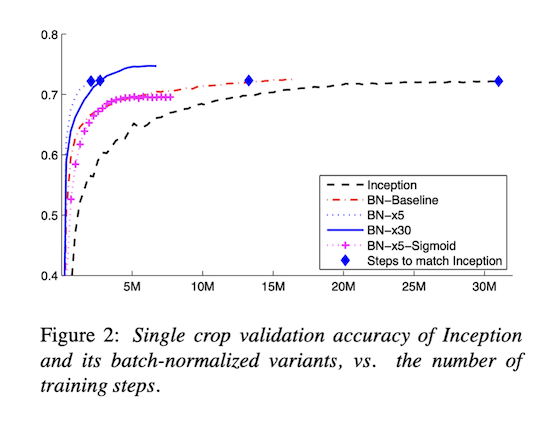

One more thing on BatchNorm before you will add it to your neural network for CIFAR classification: BatchNorm is also believed to help with the **internal covariate shift** in neural networks.

What is internal covariate shift: Each layer of the network during training must adjust to the values that the previous layer produces. During network training, the distributions of values ​​that each layer of the network produces change. And each hidden layer at each iteration of the algorithm has to adjust to the new distribution of the outputs of the previous layer. This makes training process less effective, it slows down the convergence.

BatchNorm should help with this problem, as it stabilises the distributions of layers outputs. However, the fact that BatchNorm has something to do with internal covariate shift is not proved.

Note, however, that **you will not need to do these computations during training or inference when building neural network with PyTorch**. All this behaviour is implemented inside BatchNorm layer. You need just to add it to your neural network!

### Task 3.1 Add BatchNorm to your network (10 points)

**Now to the practical part:**

BatchNorm layer in PyTorch is defined as [torch.nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html). Your task is to add this layer after one or more hidden layers in your network for CIFAR classification. Experiment with where to add BatchNorm. Maybe you'll need to modify an architecture of you network to achieve better results, but start with the architecture you've built in the Task 2.

Try to answer the following questions:
- How does the performance of your network change when adding BatchNorm? Is it able to achieve better accuracy on validation/test data than without BatchNorm?
- Is your network able to achieve same accuracy in smaller amount of training iterations?
- Are you able to build a bigger model with BatchNorm and not get overfitting?
- Does optimal network architecture with BatchNorm differ from that of without BatchNorm?

**Answers**

1. Just after adding BatchNorm after every layer accuracy improved by approximately 2%, on training loss curve much faster convergence can be observed, validation and test losses became noticeably less.

2. Yes, the network acieves the same accuracy more than 10 times faster (after 10th epoch it is already better than previous model in the end).

3. Yes, BatchNorm helps to reduce overfitting and allows to efficiently build more complex models with better performance.

4. Yes, with BatchNorm the optimal network became wider (more neurons in layers) but a bit more shallow (less layers) and achieved sufficiently better accuracy. Also due to sufficiently faster convergence training process took 5 times less epochs.

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 768), nn.BatchNorm1d(768), nn.ReLU())

        self.hidden_layer_1 = nn.Sequential(nn.Linear(768, 768), nn.BatchNorm1d(768), nn.ReLU())
        self.hidden_layer_2 = nn.Sequential(nn.Linear(768, 768), nn.BatchNorm1d(768), nn.ReLU())
        
        self.classifier = nn.Linear(768, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)

        x = self.classifier(x)

        return x

net = Net()

sum([p.numel() for p in net.parameters()])

3553546

In [21]:
train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

There's one more thing you need to know: as we've seen, behaviour of BatchNorm is slightly different during training and during inference. Indeed, we calculate $\mu_B$ and $\sigma_B$ based on current mini-batch suring training, and we use pre-calculated $\mu_r$ and $\sigma_r$ on inference. So we need to switch between these two regimes when training and evaluating our network.

It is done using `.train()` and `.eval()` methods as follows:

In [22]:
# turns on the training mode for all model layers
net.train()
# turns on the inference mode for all model layers
net.eval()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (in_layer): Sequential(
    (0): Linear(in_features=3072, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden_layer_1): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (hidden_layer_2): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (classifier): Linear(in_features=768, out_features=10, bias=True)
)

So we'll need to add this to our training function:

In [23]:
# already done

Also don't forget to turn on `eval` mode when testing your model! Or you can add `model.eval()` inside the evaluation function.

After that, create you network with BatchNorm, define loss function & optimiser, thain that in training data and test in on testing data.

Training Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1/20]  Train Loss: 1.6683  Val Loss: 1.5274
Epoch [2/20]  Train Loss: 1.4639  Val Loss: 1.4311
Epoch [3/20]  Train Loss: 1.3726  Val Loss: 1.3969
Epoch [4/20]  Train Loss: 1.3128  Val Loss: 1.3431
Epoch [5/20]  Train Loss: 1.2682  Val Loss: 1.3123
Epoch [6/20]  Train Loss: 1.2250  Val Loss: 1.2878
Epoch [7/20]  Train Loss: 1.1906  Val Loss: 1.2671
Epoch [8/20]  Train Loss: 1.1583  Val Loss: 1.2430
Epoch [9/20]  Train Loss: 1.1256  Val Loss: 1.2514
Epoch [10/20]  Train Loss: 1.1034  Val Loss: 1.2510
Epoch [11/20]  Train Loss: 1.0750  Val Loss: 1.2330
Epoch [12/20]  Train Loss: 1.0491  Val Loss: 1.2268
Epoch [13/20]  Train Loss: 1.0253  Val Loss: 1.2123
Epoch [14/20]  Train Loss: 1.0001  Val Loss: 1.2396
Epoch [15/20]  Train Loss: 0.9816  Val Loss: 1.2113
Epoch [16/20]  Train Loss: 0.9594  Val Loss: 1.2082
Epoch [17/20]  Train Loss: 0.9468  Val Loss: 1.2019
Epoch [18/20]  Train Loss: 0.9157  Val Loss: 1.2133
Epoch [19/20]  Train Loss: 0.8918  Val Loss: 1.1944
Epoch [20/20]  Train 

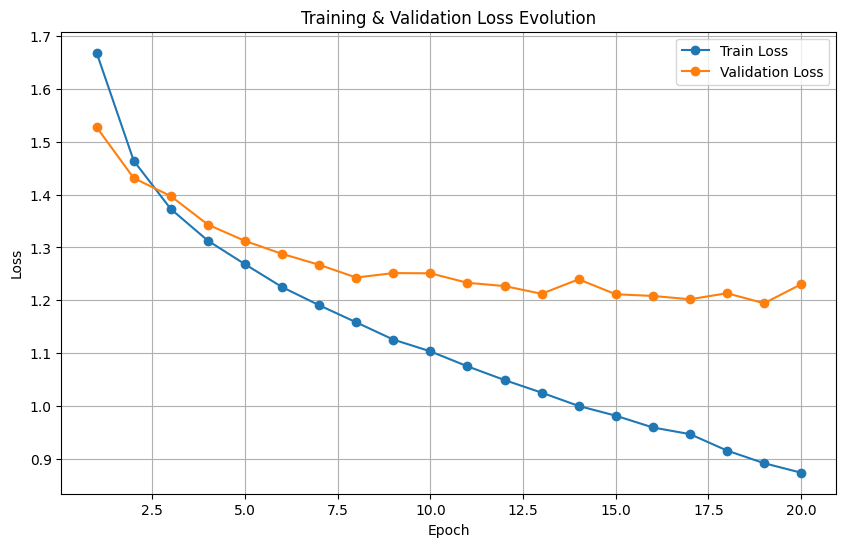

Best model weights loaded.


In [24]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

# run training
num_epochs = 20
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [25]:
evaluate(best_net, test_loader, criterion)

(1.1819366477429867, 0.5761)

### Dropout

Dropout is another powerful technique that helps make training more efficient and reduce overfitting.

Dropout can be seen as adaptation of model ensembling technique to neural networks. Let us remind ourselves first, what model ensembling is.

Model ensembling is one of the most powerful techniques in machine learning, while being really simple. The idea is to train not one, but several models for the same task on the same training data, and then average their predictions during inference. If all of the trained models are good enough in solving the task, then averaging their predictions will lead to better performance on the task than that of each individual model. It's a little tricky what "model is good enough on the task" and "better performance on the task" mean, but here's an example: if we solve the task of binary classification, "good enough" could mean that every model in the ensemble gets accuracy > 0.5 on the test data.

Intuitively, the power of ensembling can be seen as follows: models in an ensemble make mistakes on different data samples, and averaging model predictions smoothes these mistakes, i.e. one model compensates mistakes made by another model.

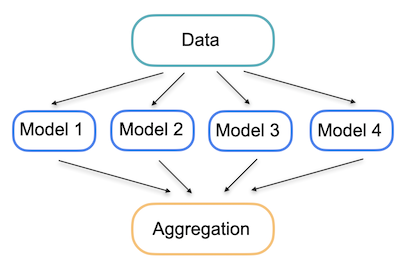

It is also important that models in an ensemble should be diverse enough. (You've already seen this when you discussed self-consistency.) That is logical: there is no point in averaging predictions of similar models, as they make the same mistakes on the same samples. To ensure diversity of models in an ensemble, [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) of training data is often used. Ideas of bootstrapping combined with emsembling leads to the well-known idea of **[Bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating)** (**B**ootstrap **Agg**regating). We will not further dive into bootstrapping or bagging here, but we encourage you to read about it.

So if ensembling is such a powerful technique, then **can we apply ensembling to neural networks as well**, can't we? Well, we can, but averaging predictions of many trained neural networks is costly. First, we would need to train many neural networks for the same task, and this would require much computational recourses and time. Second, this would slow down the inference and make it more costly as well, as we would need to get predictions from many models for each input object.

**Dropout is a technique that imitates ensembling of neural networks using only one neural network.**



The idea is the following: before training, let's choose a value of $p \in [0, 1]$. Then, during training, on each mini-batch we will "turn off" each neuron in our network with probability $p$. "Turning off" means that this neuron will not participate in forward pass og the network. Or it can be seen as neuron that is "turned off" outputting zero on a current mini-batch.

This can be visualised as follows:

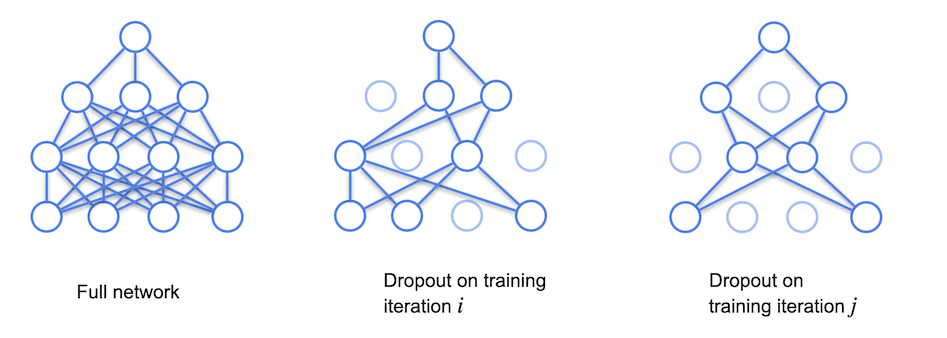

In code, "turning off" neurons in the layer can be done via simple masking. So if we apply Dropout to ф fully-connected layer, we first calculate all the neurons' outputs as usual. Then we sample a mask of zeros and ones, and each element of the mask is zero with probability $p$. After that we multiply layer output with the mask in an element-wise manner. Here is the illustration of the process:

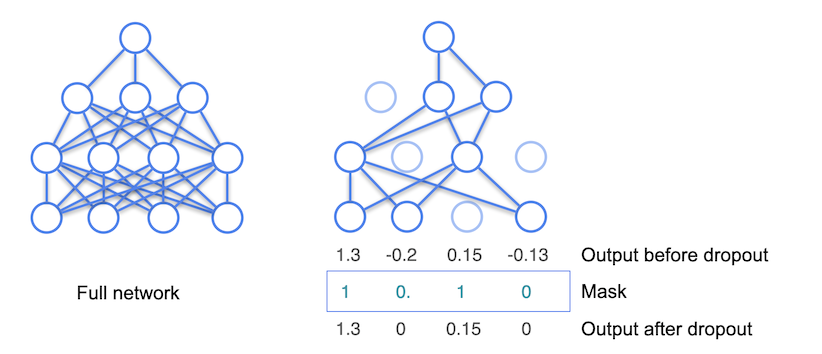

**What are the benefits of Dropout and how it is connected to ensembling:**

When using Dropout, we train a slightly different neural network (a subnetwork of the whole model) on each training iteration. This can be seen as training many different models on the same training data, outputs of which will then be aggregated on inference. However, there are differences between vanilla ensembling and Dropout:
- Each subnetwork is trained on a tiny fraction of data (mini-batch), and only for one iteration. In canonical ensembling, each models is trained on its training data until convergence
- All the subnetworks share weights, i.e. they are all parts of one whole model. In canonical ensembling all the models are completely independent
- Using Dropout, we can have exponential number of subnetworks, while in canonical ensembling there are normally 10-20 models in total

Beside this, Dropout has a nice regularisation effect on a neural network — it helps reduce overfitting. To better understand this, let's assume we've applied dropout to the layer of the network. And let's now consider one of the neurons in the subsequent layer of the network:

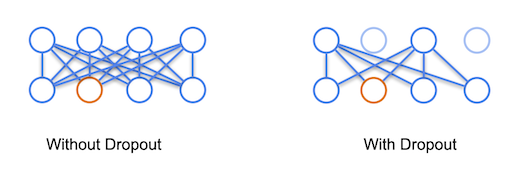

If we were not using dropout, this neron could overfit to specific information coming from the previous layer. So the previous layer has 4 neurons, and our orange neuron gets information from all of them. It might happen that during training this orange neuron learns to rely only on the information coming from only one of these 4 neurons from the previous layer; let's say the leftmost neuron. This might be expressed by the weight between the left neuron of the previous layer and our orange neuron being big, and other weights being small. This would mean that our orange neuron heavily relies on the information coming from only one neuron of the previous layer.

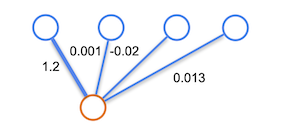

This would mean that our orange neuron has overfitted on the specific information coming from one particular neuron of the previous layer. And decision of orange neuron will be extremely bad in cases when output of this neuron of the previous layer is corrupted, or out-of-distrubution.

We can look at it from the following perspective: each neuron in the network reacts to the specific information present on the input object. If we are solving face recognition problem, a neuron might, for exmaple, extract information about some aspect of person's face, e.g. nose. It might happen that in the training data, there were only images of people's faces with noses visible, but in test data we can get an image of a person in a mask. In this case, the output of the neuron reacting to noses will be non-informative, or corrupted. And if our orange neuron relies heavily on the information coming from that neuron, it won't be able to produce meaningful output, too.

When using Dropout, we sometimes break the connection between the orange and each of the neurons in the previous layer. This makes our orange neuron produce meaningful output based on different combinatioins of features coming from previous layer. So if one of these features becomes corrupted, our neuron will still be able to generate meaningful output based on other features coming from different neurons of the previous layer.

To sum up, training with dropout makes neurons be able to perform well regardless of which other hidden units are in the model. It prevents units from forming “distinct pattern ways”, makes each unit be able to work with different input patterns. **This makes model more robust to unusual data perturbations and reduces overfitting**.


Ok, we've understood how to use Dropout during training and what benefits it provides. Now let's see **how to perform Dropout during inference**.

If we follow idea of ensembling, we should average predictions of all the models in our ensemble. But we can't do that, as we have sampled a new model on each training iteration. We could probably sample 10-20 such models (i.e. sample 10-20 versions of network with Dropout) and average their predictions on test data, but this is still costly.

Instead of doing actual ensembing, we will do the following: let's just disable Dropout during inference. But if we simply do that, this will change the expected value coming to neuron of the next layer. Imagine a neuron connected to 4 neurons of the previous layer. If we used Dropout with $p=0.5$ during training, this neuron got used to getting about half of the outputs of previous layer's neurons. If we simply disable Dropout on inference, this neuron will suddenly start getting two times more outputs, which can break its behaviour.

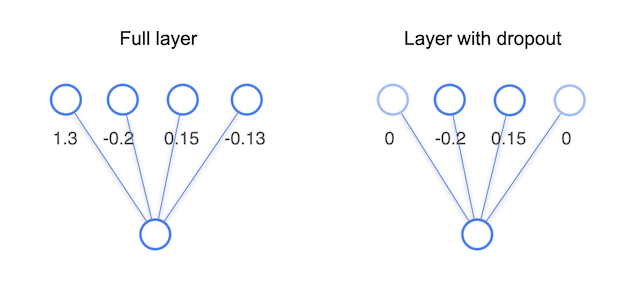

Let's compensate this. First, let's reformulate the problem: we said that the expected input value of neuron of the next layer changes if we disable Dropout. It can also be seen from another perspective: expected value of output of each neuron on the layer with Dropout changes when we disable Dropout. Indeed, each neuron's output was zeroed with probability $p$ during training, and now it is never zeroed, meaning the expected value has risen by fraction of $\frac{1}{p}$. So let's fix this. We can do it by simply multipying outputs of each neuron in the layer by $p$ during inference:

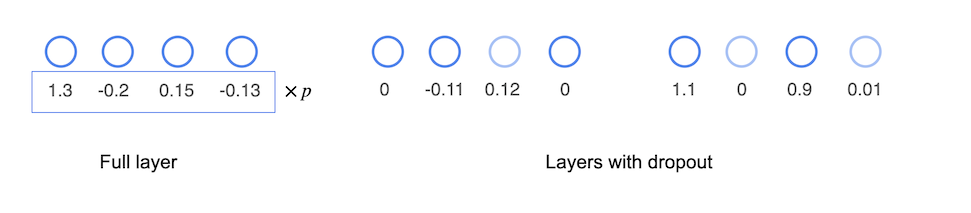

This will fix the expected value of output of each neuron during inference. In practice, however, it is more efficient to multiply outputs of neurons by $\frac{1}{p}$ during training instead. This will save time on inference, as we will not need to do another multiplication.

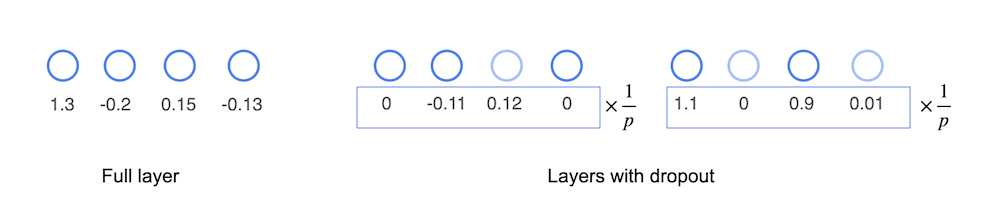

Note, however, that **you will not need to multiply anything during training or inference when building neural network with PyTorch**. All this behaviour is implemented inside Dropout layer. You need just to add it to your neural network!

So that's it! Now let's switch to practice, and add Dropout to our neural network!

### Task 3.2 Add Dropout to your network (10 points)

**Now to the practical part:**

BatchNorm layer in PyTorch is defined as [torch.nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Your task is to add this layer after one ore more hidden layers in your network for CIFAR classification. Experiment with where to add Dropout and what $p$ to choose. Maybe you'll need to modify an architecture of you network to achieve better results, but start with the architecture you've built in the Tasks 2 and 3.1. Try to use Dropout without BatchNorm, and then try to use Dropout with BatchNorm.

Try to answer the following questions:
- How does the performance of your network change when adding Dropout? Is it able to achieve better accuracy on validation/test data than without Dropout?
- Is it beneficial to use both Dropout and BatchNorm?
- Are you able to build a bigger model with Dropout and not get overfitting?
- What values of $p$ are optimal?
- Does optimal network architecture with BatchNorm differ from that of without BatchNorm?

**Don't forget to use `model.train()` and `model.eval()`**, as behaviour of Dropout also changes between train and inference.

**Answers**

1. Just after adding Dropout with p=0.25 after every layer in architecture built in task 2.4 overfitting was occuring only after ~100th epoch (vs 60th in 2.4) and accuracy improved by ~2%. Training convergence slowed down, validation loss got closer to training.

2. Just after adding Dropout with p=0.25 after every layer in architecture built in task 3.1 overfitting was occuring only after ~100th epoch (vs 20th in 3.1) and accuracy improved by ~4%. Training convergence slowed down, validation loss got closer to training and became sufficiently less, so yes, it is beneficial to use both regularisation techniques there.

3. Yes, with dropout overfitting occurs later and better performance can be reached. For example, a model with 9.5M parameters can reach accuracy of ~65% with Dropout and no overfitting.

4. As it seems to me, optimal values for $p$ are between 0.25 and 0.5 for this task, but it also depends on model architecture.

5. I suppose the question was about Dropout, not BatchNorm. So the optimal model architecture I have found with Dropout differs from architecture with only BatchNorm. The layers became wider and epochs number increased because convergence slowed down, but the accuracy sufficiently increased.

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 1536), nn.BatchNorm1d(1536), nn.ReLU(), nn.Dropout(p=0.5)) 
        # there we set p
        # the higher values there mean the stronger regularization and the slower convergence
        # as well as the higher underfitting risk

        self.hidden_layer_1 = nn.Sequential(nn.Linear(1536, 1536), nn.BatchNorm1d(1536), nn.ReLU(), nn.Dropout(p=0.5))
        self.hidden_layer_2 = nn.Sequential(nn.Linear(1536, 1536), nn.BatchNorm1d(1536), nn.ReLU(), nn.Dropout(p=0.5))
        
        self.classifier = nn.Linear(1536, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)

        x = self.classifier(x)

        return x

net = Net()

sum([p.numel() for p in net.parameters()])

9466378

In [27]:
train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

After that, create you network with Dropout, define loss function & optimiser, thain that in training data and test in on testing data.

Training Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250]  Train Loss: 1.9409  Val Loss: 1.6834
Epoch [2/250]  Train Loss: 1.7335  Val Loss: 1.5838
Epoch [3/250]  Train Loss: 1.6614  Val Loss: 1.5323
Epoch [4/250]  Train Loss: 1.6085  Val Loss: 1.4913
Epoch [5/250]  Train Loss: 1.5687  Val Loss: 1.4649
Epoch [6/250]  Train Loss: 1.5345  Val Loss: 1.4322
Epoch [7/250]  Train Loss: 1.5103  Val Loss: 1.4165
Epoch [8/250]  Train Loss: 1.4849  Val Loss: 1.3997
Epoch [9/250]  Train Loss: 1.4706  Val Loss: 1.3814
Epoch [10/250]  Train Loss: 1.4498  Val Loss: 1.3640
Epoch [11/250]  Train Loss: 1.4359  Val Loss: 1.3532
Epoch [12/250]  Train Loss: 1.4192  Val Loss: 1.3479
Epoch [13/250]  Train Loss: 1.4059  Val Loss: 1.3314
Epoch [14/250]  Train Loss: 1.3947  Val Loss: 1.3249
Epoch [15/250]  Train Loss: 1.3814  Val Loss: 1.3106
Epoch [16/250]  Train Loss: 1.3700  Val Loss: 1.3053
Epoch [17/250]  Train Loss: 1.3608  Val Loss: 1.2908
Epoch [18/250]  Train Loss: 1.3545  Val Loss: 1.2868
Epoch [19/250]  Train Loss: 1.3382  Val Loss: 1.2744
Ep

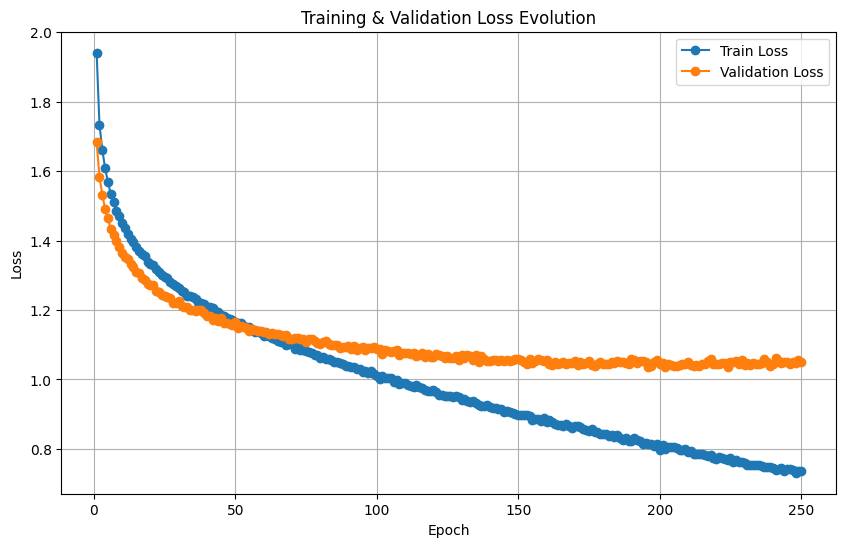

Best model weights loaded.


In [28]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

# run training
num_epochs = 250
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [29]:
evaluate(best_net, test_loader, criterion)

(1.0160659492015838, 0.6556)

## Task 4. Having the best of it all. (35 points)

Finally, your task is to make experiments and build the best possible model for CIFAR classification and write a report on it. If you've made experiments in the tasks above, that's fine, you now only need to reflect on your experiments and create a report.

Hints on experimenting (some of them aare from Task 2):
- Start with no more than 2-3 hidden layers each having 5-7 neurons
- Think about how many neurons your input and output layers should have
- What activation function do you need to use in the last layer?
- Play with number of layers, numbers of neurons in layers, different activation functions
- Try different training **hyperparameters**: learning rate, number of epochs, type of optimizer, batch size, something else?
- Try different configurations of BatchNorm/Dropout
- Try different kinds of image preprocessing inside you Dataset class, e.g. resizing/normalising images, etc. Does optimal preprocesing differ when using Dropout/BatchNorm than that of for the network without Dropout/BatchNorm?

After you've done experimenting, document your experiments and describe your findings. Try to answer the following questions:
- What is maximum accuracy on test test that you were able to achieve? Do you think it is possible to get higher accuracy using fully-connected network? Why?
- Have you observed overfitting? When does it start, i.e. how big the network should be?
- How does the behaviour of the model change when you change different hyperparameters?
- What interesting behaviour have you observed? What was beneficial and what did not influence the model?

Here is also a hint on experimenting: try to change one parameter at time. When you change the parameter, retrain the network and see how the behaviour has changes. Log the results, so you can then a general picture of how each parameter influences the model training. This will also help you not to forget what you have already tried.

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()
        
        self.in_layer = nn.Sequential(nn.Linear(3 * 32 * 32, 1536), nn.BatchNorm1d(1536), nn.ReLU(), nn.Dropout(p=0.5)) 

        self.hidden_layer_1 = nn.Sequential(nn.Linear(1536, 1536), nn.BatchNorm1d(1536), nn.ReLU(), nn.Dropout(p=0.5))
        self.hidden_layer_2 = nn.Sequential(nn.Linear(1536, 1536), nn.BatchNorm1d(1536), nn.ReLU(), nn.Dropout(p=0.5))
        
        self.classifier = nn.Linear(1536, 10)

    def forward(self, x):
        x = self.flatten(x)

        x = self.in_layer(x)

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)

        x = self.classifier(x)

        return x

net = Net()

sum([p.numel() for p in net.parameters()])

9466378

In [31]:
train_loader.dataset.dataset.transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

Training Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250]  Train Loss: 1.9393  Val Loss: 1.6804
Epoch [2/250]  Train Loss: 1.7359  Val Loss: 1.5888
Epoch [3/250]  Train Loss: 1.6569  Val Loss: 1.5373
Epoch [4/250]  Train Loss: 1.6039  Val Loss: 1.4910
Epoch [5/250]  Train Loss: 1.5663  Val Loss: 1.4723
Epoch [6/250]  Train Loss: 1.5320  Val Loss: 1.4371
Epoch [7/250]  Train Loss: 1.5137  Val Loss: 1.4211
Epoch [8/250]  Train Loss: 1.4885  Val Loss: 1.4048
Epoch [9/250]  Train Loss: 1.4684  Val Loss: 1.3870
Epoch [10/250]  Train Loss: 1.4500  Val Loss: 1.3630
Epoch [11/250]  Train Loss: 1.4361  Val Loss: 1.3466
Epoch [12/250]  Train Loss: 1.4188  Val Loss: 1.3350
Epoch [13/250]  Train Loss: 1.4058  Val Loss: 1.3212
Epoch [14/250]  Train Loss: 1.3884  Val Loss: 1.3218
Epoch [15/250]  Train Loss: 1.3793  Val Loss: 1.3046
Epoch [16/250]  Train Loss: 1.3680  Val Loss: 1.2923
Epoch [17/250]  Train Loss: 1.3601  Val Loss: 1.2917
Epoch [18/250]  Train Loss: 1.3554  Val Loss: 1.2805
Epoch [19/250]  Train Loss: 1.3391  Val Loss: 1.2771
Ep

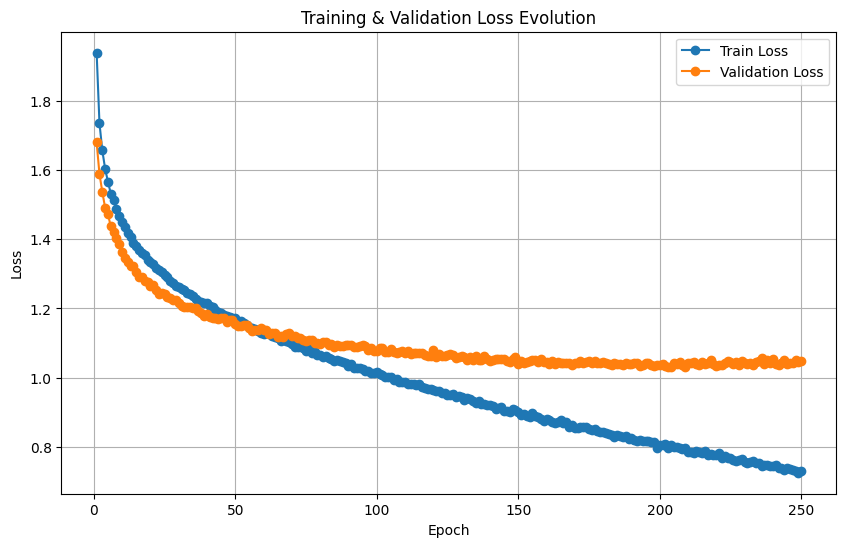

Best model weights loaded.


In [32]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-4)

# run training
num_epochs = 250
best_net = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [33]:
evaluate(best_net, test_loader, criterion)

(1.0260625340044498, 0.655)

**YOUR REPORT HERE**

1. Maximum accuracy I achieved on test set was more than 65%. I think it is quite difficult to get sufficiently better results because it seems that FC networks haven't really good generalization properties working with images because they don't respect the data structure.
2. There is another example of observed overfitting. In this case I've trained the same model as in task 2.4 the same number of epochs, but with BatchNorm after each layer:

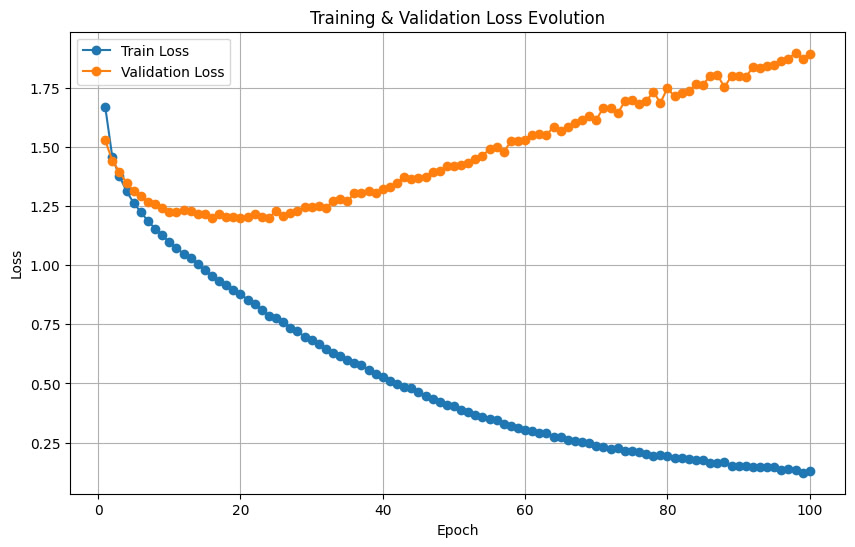

3. 
- LR increases $\longrightarrow$ faster convergence, higher overfitting risk and instability
- LR decreases $\longrightarrow$ slower convergence, slower training process
- Number of epochs increases $\longrightarrow$ more likely to catch overfitting
- Number of epochs decreases $\longrightarrow$ less likely to catch overfitting, but underfitting possibility
- Larger batch size $\longrightarrow$ more stable training process, larger memory consumption
- Smaller batch size $\longrightarrow$ noisier weights updates

4. 
- Augmentation can boost model's performance, for example RandomHorizontalFlip and RandomRotation were helpful
- torch.nn.ReLU() activation function shows better results than torch.nn.Tanh() and works faster

**See experiments in 2.4.**